## Import Needed Libraries

In [1]:
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from scipy.sparse import csr_matrix
import os
import re
import time
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## Define Functions to Produce Character N-grams 

In [2]:
def ngram(txt, n, ngrams):
    r""" Takes in a list of characters and combines them into character
    n-grams of specified length
    """
    
    for i in range(0,len(txt)-n+1):
        ngram = txt[i:i+n]
        ngrams.append(" ".join(ngram))

    return ngrams

In [3]:
def tokenizeArticle(filename, ngramLen):
    r""" Takes in file and outputs a set of character n-grams
    """
    
    # load text
    file = open(filename, 'rt')
    text = file.read()
    file.close()

    # Extract characters from text (alphabetical, ' and -)
    word_tokens = re.findall(r"[A-Za-z '-]",text)
    
    # Convert all characters to lowercase
    Words = [word.lower() for word in word_tokens]

    # Extract character n-grams
    words = []
    for n in ngramLen:
        w = ngram(Words,n,words)
    
    return words

In [4]:
def article2ngrams(ngramLength):
    # Initialize variables to store author for each article and word tokenization matrix
    authorCount = 0
    authorID = []
    articleDB = []

    # Loop through each author directory within training set
    dataDir = os.listdir('data/C50train')
    for dDir in dataDir:

        # Loop through each article within author directory
        authorDir = os.listdir('data/C50train/' + dDir)
        for aDir in authorDir:

            # Tokenize each article and store author ID
            articleDB.append(tokenizeArticle('data/C50train/' + dDir + '/' + aDir,ngramLength))
            authorID.append(authorCount)
        
        # Increment author id for next author
        authorCount = authorCount + 1

    # Loop through each author directory within testing set
    authorCount = 0
    dataDir = os.listdir('data/C50test')
    for dDir in dataDir:

        # Loop through each article within author directory
        authorDir = os.listdir('data/C50test/' + dDir)
        for aDir in authorDir:

            # Tokenize each article and store author ID
            articleDB.append(tokenizeArticle('data/C50test/' + dDir + '/' + aDir,ngramLength))
            authorID.append(authorCount)
        
        # Increment author id for next author
        authorCount = authorCount + 1
        
    return articleDB, authorID

## Define Functions to Reduce and Normalize Data 

In [5]:
def filterSize(DB, arraySize):
    r""" Filters dataset down to the N most frequent character n-grams
    """
    
    # Calculate Document Frequency
    df = defaultdict(int)
    for d in DB:
        for w in set(d):
            df[w] += 1
    
    # Determine word of the most common occurrence
    count = 1
    dnew = defaultdict(int)
    for key in sorted(df.items(), key=lambda item: item[1], reverse=True):
        dnew[key[0]] = count
        count = count + 1
    
    return [ [t for t in d if dnew[t] <= arraySize] for d in DB ]

In [6]:
def build_matrix(docs):
    r""" Build sparse matrix from a list of documents, 
    each of which is a list of word/terms in the document.  
    """
    nrows = len(docs)
    idx = {}
    tid = 0
    nnz = 0
    for d in docs:
        nnz += len(set(d))
        for w in d:
            if w not in idx:
                idx[w] = tid
                tid += 1
    ncols = len(idx)
        
    # set up memory
    ind = np.zeros(nnz, dtype=np.int)
    val = np.zeros(nnz, dtype=np.double)
    ptr = np.zeros(nrows+1, dtype=np.int)
    i = 0  # document ID / row counter
    n = 0  # non-zero counter
    # transfer values
    for d in docs:
        cnt = Counter(d)
        keys = list(k for k,_ in cnt.most_common())
        l = len(keys)
        for j,k in enumerate(keys):
            ind[j+n] = idx[k]
            val[j+n] = cnt[k]
        ptr[i+1] = ptr[i] + l
        n += l
        i += 1
            
    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    mat.sort_indices()
    
    return mat


def csr_info(mat, name="", non_empy=False):
    r""" Print out info about this CSR matrix. If non_empy, 
    report number of non-empty rows and cols as well
    """
    if non_empy:
        print("%s [nrows %d (%d non-empty), ncols %d (%d non-empty), nnz %d]" % (
                name, mat.shape[0], 
                sum(1 if mat.indptr[i+1] > mat.indptr[i] else 0 
                for i in range(mat.shape[0])), 
                mat.shape[1], len(np.unique(mat.indices)), 
                len(mat.data)))
    else:
        print( "%s [nrows %d, ncols %d, nnz %d]" % (name, 
                mat.shape[0], mat.shape[1], len(mat.data)) )

In [7]:
def td_idf(dbMat):
    r""" Normalizes the sparse matrix based on Term Frequency, Inverse Document
    Frequency normalization
    """
    # Get Data from Sparse Matrix
    nrows = dbMat.shape[0]
    nnz = dbMat.nnz
    ind, val, ptr = dbMat.indices, dbMat.data, dbMat.indptr
    
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1

    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  ## df turns to idf - reusing memory
    
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
    
    return dbMat

In [8]:
def l2norm(dbMat):
    r""" Normalizes the sparse matrix based on L2 Normalization
    """
    
    # Get Data from Sparse Matrix
    nrows = dbMat.shape[0]
    nnz = dbMat.nnz
    ind, val, ptr = dbMat.indices, dbMat.data, dbMat.indptr
    
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
    
    return dbMat

## Perform N-gram Length and Feature Number Analysis 

In [9]:
# Define ngram length and feature size to iterate over
ngramsLength = [[3],[4],[5],[3,4,5]]
parmSize = [7000, 6000, 5000, 4000, 3000, 2000, 1000, 500]

# Initialize score metric lists
prs = []
res = []
f1 = []

for nL in ngramsLength:
    
    # Convert articles to character n-grams
    print('Character N-grams Used: ', nL)
    articleDB, authorID = article2ngrams(nL)
    
    # Initialize inner loop score metric list
    prsInner = []
    resInner = []
    f1Inner  = []
    
    for i in range(0,len(parmSize)):
        start = time.time()
    
        # Down select features
        DB = filterSize(articleDB, parmSize[i])
    
        # Create CSR matrix
        mat = build_matrix(DB)
        csr_info(mat)
    
        # Normalize Data
        mat = td_idf(mat)
        mat = l2norm(mat)
    
        # split training/testing data
        X_train, X_test, y_train, y_test = train_test_split(mat, authorID, test_size=0.2, random_state=42)
    
        # Run SVM Classifier
        svclassifier = SVC(kernel='rbf',C=10)
        svclassifier.fit(X_train, y_train)
        pr = svclassifier.predict(X_test)
    
        # Get Results
        prsInner.append(precision_score(y_test, pr, average = 'weighted'))
        resInner.append(recall_score(y_test, pr, average = 'weighted'))
        f1Inner.append(f1_score(y_test, pr, average = 'weighted'))
        print('Number of components = ', parmSize[i])
        print('precision score = ', prsInner[i])
        print('recall score = ', resInner[i])
        print('f1 score = ', f1Inner[i])
    
        end = time.time()
        duration = end-start
        print("Time taken to train: %d seconds" %duration)
        
    # Store Scoring Metrics
    prs.append(prsInner)
    res.append(resInner)
    f1.append(f1Inner)

Character N-grams Used:  [3]
 [nrows 5000, ncols 7000, nnz 5206345]
Number of components =  7000
precision score =  0.8322407849964331
recall score =  0.819
f1 score =  0.8192279288390829
Time taken to train: 258 seconds
 [nrows 5000, ncols 6000, nnz 5186692]
Number of components =  6000
precision score =  0.8310257364779176
recall score =  0.82
f1 score =  0.8200921262118746
Time taken to train: 251 seconds
 [nrows 5000, ncols 5000, nnz 5150728]
Number of components =  5000
precision score =  0.8314598877313969
recall score =  0.819
f1 score =  0.8191955012682313
Time taken to train: 271 seconds
 [nrows 5000, ncols 4000, nnz 5078882]
Number of components =  4000
precision score =  0.8364982501828103
recall score =  0.824
f1 score =  0.8245377921064331
Time taken to train: 264 seconds
 [nrows 5000, ncols 3000, nnz 4920382]
Number of components =  3000
precision score =  0.8396512102703191
recall score =  0.828
f1 score =  0.8275248523368652
Time taken to train: 250 seconds
 [nrows 5000

In [10]:
print(prs)
print(res)
print(f1)

[[0.8322407849964331, 0.8310257364779176, 0.8314598877313969, 0.8364982501828103, 0.8396512102703191, 0.833897773081615, 0.8296436526900764, 0.7916592113484978], [0.8347512442529895, 0.8344113258714613, 0.836727901033795, 0.8393479810897614, 0.8286718748421966, 0.8292946845852059, 0.8111628813639733, 0.7894557125605732], [0.8444436564825344, 0.8445978515994508, 0.8427303988299949, 0.842570360687476, 0.8369235103038158, 0.8213710658480853, 0.7842014293009872, 0.747620022046946], [0.8360583494430797, 0.8301802883234486, 0.8293627908554728, 0.831407556115688, 0.8336998910816329, 0.8265420017215253, 0.8223679889613037, 0.7637712290398762]]
[[0.819, 0.82, 0.819, 0.824, 0.828, 0.824, 0.821, 0.786], [0.825, 0.826, 0.829, 0.831, 0.82, 0.825, 0.8, 0.779], [0.836, 0.836, 0.834, 0.834, 0.825, 0.815, 0.774, 0.734], [0.83, 0.826, 0.824, 0.825, 0.824, 0.817, 0.811, 0.756]]
[[0.8192279288390829, 0.8200921262118746, 0.8191955012682313, 0.8245377921064331, 0.8275248523368652, 0.8237655295709133, 0.8198

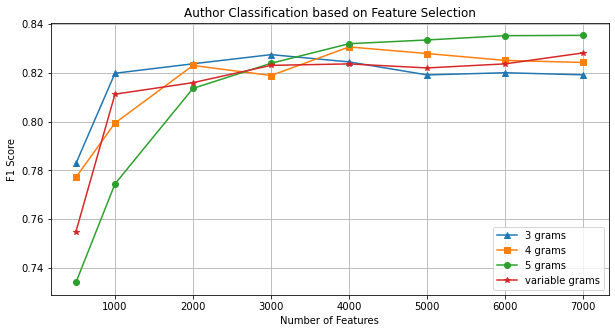

In [11]:
# Create a Figure
fig = plt.figure(figsize=(10,5))

# Plot Features vs F1 Score for the different n-grams
line1, = plt.plot(parmSize,f1[0],'-^',label='3 grams')
line2, = plt.plot(parmSize,f1[1],'-s',label='4 grams')
line3, = plt.plot(parmSize,f1[2],'-o',label='5 grams')
line4, = plt.plot(parmSize,f1[3],'-*',label='variable grams')
plt.title('Author Classification based on Feature Selection')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.grid(axis='both')
plt.legend(handles=[line1, line2, line3, line4])

## Perform SVM C-Value Analysis

In [12]:
# Define C-values to iterate over
cValue = [0.1,0.2,0.3,0.4,0.5,0.7,1,2,5,10,100,1000,10000,100000]

# Initialize score metric variables
f1_list = []
f1_avg = []

# Convert articles to character n-grams
articleDB, authorID = article2ngrams([5])
    
# Down select features
DB = filterSize(articleDB, 4000)

# Create CSR matrix
mat = build_matrix(DB)
csr_info(mat)
    
# Normalize Data
mat = td_idf(mat)
mat = l2norm(mat)

for i in range(0,len(cValue)):
    start = time.time()
   
    # Run SVM Classifier
    svc = SVC(kernel='rbf',C=cValue[i])
    k_fold = KFold(n_splits=6, shuffle=True, random_state=20)
    
    # Run Cross Validation
    f1_sc = cross_val_score(svc, mat, authorID, cv=k_fold, n_jobs=-1, scoring='f1_weighted')
    f1_list.append(f1_sc)
    f1_avg.append(np.mean(f1_sc))

    end = time.time()
    duration = end-start
    print("Time taken to train: %d seconds" %duration)

 [nrows 5000, ncols 4000, nnz 4502239]
Time taken to train: 281 seconds
Time taken to train: 303 seconds
Time taken to train: 284 seconds
Time taken to train: 270 seconds
Time taken to train: 279 seconds
Time taken to train: 290 seconds
Time taken to train: 298 seconds
Time taken to train: 290 seconds
Time taken to train: 287 seconds
Time taken to train: 304 seconds
Time taken to train: 282 seconds
Time taken to train: 276 seconds
Time taken to train: 275 seconds
Time taken to train: 276 seconds


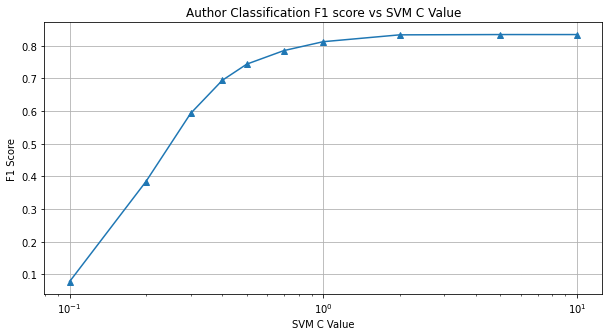

In [14]:
fig = plt.figure(figsize=(10,5))

line1, = plt.plot(cValue[0:10],f1_avg[0:10],'-^')

plt.title('Author Classification F1 score vs SVM C Value')
plt.xlabel('SVM C Value')
plt.ylabel('F1 Score')
plt.grid(axis='both')
plt.xscale('log')